In [8]:
#from ipywidgets import interact, widgets
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import anuga
import numpy as np
from anuga.utilities import plot_utils as pu

# some annoying userwarning when opening excel files 
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')

Read in Parameters

In [9]:
params = {}
params['flow_data'] = 'flows_2021'  #'flows_1990' 'flows_1989'
params['dam_height'] = 116.
params['reservoir_stage'] = 115.831
params['max_area'] = 10000 # 40000


flow_data = params['flow_data']
dam_height = params['dam_height']
reservoir_stage = params['reservoir_stage']
max_area = params['max_area']

In [10]:
station_data = {212241: ['212241.xlsx', -33.87694444, 150.6063889, 100.0, 'outflow', (0.0, 0.0)],
            212250: ['212250.xlsx', -33.87124191, 150.2540137, 100.0, 'inflow', (10.0, 10.0)],
            212270: ['212270.xlsx', -34.22765922, 150.2527921, 1000.0, 'inflow', (10.0, 10.0)],
            212280: ['212280.xlsx', -34.14555579, 150.4247247, 1000.0, 'inflow', (2.0, 2.0)],
            212260: ['212260.xlsx', -33.94805556, 150.2430556, 8000.0, 'inflow', (10.0, 10.0)],
            212243: ['212243.xlsx', -33.89111111, 150.5911111, 200.0, 'dam', (0.0, 0.0)]}


import utm
import pandas
import numpy

data_dir = 'data/'+flow_data+'/'

#================================
# The station time is based on
# a time base of 1900/1/1 == time 1 day
# We will convert to one based on 
# unix timestamp (1970/1/1)
#================================
from datetime import datetime
from zoneinfo import ZoneInfo
UTC = ZoneInfo('UTC')
data_time_base = datetime(1899, 12, 30, tzinfo=UTC)
data_base_timestamp = data_time_base.timestamp()

Setup outflow station  212241
Setup inflow station  212250
Setup inflow station  212270
Setup inflow station  212280
Setup inflow station  212260
5 2 1
Total outflows  1305470087.55
Total inflows  970479692.875
Total flows  -334990394.67499995


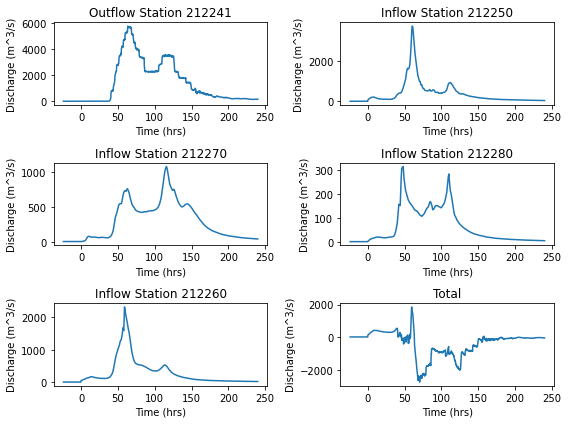

In [20]:
start_time = 1.0e200

outflow_gauges = []
outflow_totals = []
inflow_gauges = []
inflow_totals = []

fig, axs = plt.subplots(3, 2, figsize=(8,6))

axid = 0

outflow_operators = []
station_key = []
q_in_s = []
q_out_s = []

for key, value in station_data.items():

    if value[4] == 'inflow' :
        print('Setup inflow station ',key)
        unit_factor = 1000.0/(3600*24)
        lat = value[1]
        long =value[2]
        u = utm.from_latlon(lat,long)
        easting = u[0]
        northing = u[1]
        
        inflow_gauges.append([easting, northing])
        
        radius = value[3]
        station_filename = data_dir+value[0]
        
        station_key.append(str(key))

        df = pandas.read_excel(station_filename)
        #df['Time'] = df['Time'] - df['Time'][0]
        station_time = numpy.array(df['Time'])*3600*24    # convert from day to seconds
        station_time = station_time + data_base_timestamp # convert to seconds from 1/1/1970 UTC
        start_time = min(station_time[0], start_time)

        #print(numpy.max(station_time))
        #print(numpy.min(station_time))
        station_Q    = numpy.array(df['Discharge'])*unit_factor # m^3/sec
        from scipy import interpolate, integrate

        station_Q_fun = interpolate.interp1d(station_time, station_Q, fill_value=value[5], bounds_error=False)
        
        inflow_total = numpy.zeros_like(station_time)
        for k, finaltime in enumerate(station_time):
            if k == 0:
                pass
            else:
                inflow_total[k], err = integrate.quad(station_Q_fun, station_time[k-1], station_time[k], limit=1000, epsabs=100.0)
            
        inflow_totals.append(inflow_total)
        #print('Outflow Total for station ', outflow_gauges[-1], outflow_total[-1])

        
        t = numpy.linspace(start_time-3600*24,start_time+3600*24*10, 1000)
        q = station_Q_fun(t)
        q_in_s.append(q)

        t = (t - start_time)/3600

        #df.plot('Time', 'Discharge')
        #plt.show()

        ax = axs[axid//2 , axid%2]
        ax.plot(t,q)
        ax.set_title("Inflow Station "+str(key))
        ax.set_xlabel('Time (hrs)')
        ax.set_ylabel('Discharge (m^3/s)')
        
        #print(axid)
        axid += 1

        
    if value[4] == 'outflow' :
        print('Setup outflow station ',key)
        unit_factor = 1.0
        #unit_factor = 1000.0/(3600*24)
        lat = value[1]
        long =value[2]
        u = utm.from_latlon(lat,long)
        easting = u[0]
        northing = u[1]
        
        outflow_gauges.append([easting, northing])
        
        radius = value[3]
        station_filename = data_dir+value[0]
        
        station_key.append(str(key))

        df = pandas.read_excel(station_filename)
        #df['Time'] = df['Time'] - df['Time'][0]
        station_time = numpy.array(df['Time'])*3600*24    # convert from day to seconds
        station_time = station_time + data_base_timestamp # convert to seconds from 1/1/1970 UTC
        start_time = min(station_time[0], start_time)

        #print(numpy.max(station_time))
        #print(numpy.min(station_time))
        station_Q    = numpy.array(df['Discharge'])*unit_factor # m^3/sec
        from scipy import interpolate, integrate

        station_Q_fun = interpolate.interp1d(station_time, station_Q, fill_value=value[5], bounds_error=False)
        
        outflow_total = numpy.zeros_like(station_time)
        for k, finaltime in enumerate(station_time):
            if k == 0:
                pass
            else:
                outflow_total[k], err = integrate.quad(station_Q_fun, station_time[k-1], station_time[k], limit=1000, epsabs=100.0)
            
        outflow_totals.append(outflow_total)
        #print('Outflow Total for station ', outflow_gauges[-1], outflow_total[-1])

        t = numpy.linspace(start_time-3600*24,start_time+3600*24*10, 1000)
        q = station_Q_fun(t)
        q_out_s.append(q)

        t = (t - start_time)/3600

        #df.plot('Time', 'Discharge')
        #plt.show()

        ax = axs[axid//2 , axid%2]
        ax.plot(t,q)
        ax.set_title("Outflow Station "+str(key))
        ax.set_xlabel('Time (hrs)')
        ax.set_ylabel('Discharge (m^3/s)')
        
        axid += 1
        
        
inflow_totals = numpy.array(inflow_totals)
outflow_totals = numpy.array(outflow_totals)
total_outflow = numpy.sum(outflow_totals)
total_inflow  = numpy.sum(inflow_totals)

print(axid, axid//2, axid%2)
ax = axs[axid//2 , axid%2]

print('Total outflows ', total_outflow )
print('Total inflows ', total_inflow)
ax.set_title("Total")
ax.set_xlabel('Time (hrs)')
ax.set_ylabel('Discharge (m^3/s)')
print('Total flows ',  total_inflow - total_outflow )


q_in_s = numpy.array(q_in_s)
q_in = numpy.sum(q_in_s,0)

q_out_s = numpy.array(q_out_s)
q_out = numpy.sum(q_out_s,0)


#ax.plot(t,q_in)
#ax.plot(t,q_out)
ax.plot(t,q_in-q_out)
        
plt.tight_layout()
plt.show()


In [21]:
dt = (t[1]-t[0])*3600
cum_in = numpy.sum(q_in)*dt

In [22]:
cum_out = numpy.sum(q_out)*dt

In [23]:
print(cum_in, cum_out, cum_in - cum_out)

973362533.7442226 1297295543.31405 -323933009.5698273
